<a href="https://colab.research.google.com/github/indahpurwatiiii/SQL-Code/blob/main/A_B_Testing_Chi_Square.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ecommerce-ab-testing:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1379469%2F2289044%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240213%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240213T060639Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D510dd3fa1b1ab330423d2e7ee63576dfb1689d7be9cb3cd0715e2b2ac61d78c2adad9b275511d886ccc1f35a799c24c435ba2952ac0826d64fee1655034c3bc152ed5b9c1c0580237c37691111b828208258f7a8ab5afbfc872f0a3da6f6feea60047d805d41c656b8c36fe09fa0f3c790f0388b6210fab83f983fdf0237f2a489ba190cbef4d9601b6d1681716b997ec4af8bd7cecc65d80084dde13c3c9f5b30bb459512edf9b025663919c0a1c48ed27251a50fb2fc3527eba901ad4d8201d7b1b464406ab56012284386fae875a83fd84a00c522316666d39823fa53cd30614cc55a9df499f4fc59c65716e7e26a695c657fcd5743d50a3b70b4ebbe74ac'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-ab-testing/ab_test.csv
/kaggle/input/ecommerce-ab-testing/countries_ab.csv


In [ ]:
import pandas as pd
import numpy as np

# NEW LIBRARY
from scipy.stats import ttest_ind # for t-test
from scipy.stats import chi2_contingency # for chi-square test

In [ ]:
data=pd.read_csv('/kaggle/input/ecommerce-ab-testing/ab_test.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         294478 non-null  int64 
 1   time       294478 non-null  object
 2   con_treat  294478 non-null  object
 3   page       294478 non-null  object
 4   converted  294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
data=data.drop_duplicates('id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         290584 non-null  int64 
 1   time       290584 non-null  object
 2   con_treat  290584 non-null  object
 3   page       290584 non-null  object
 4   converted  290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [ ]:
control_group = data[data['con_treat'] == 'control']
treatment_group = data[data['con_treat'] == 'treatment']
control_group.info()
treatment_group.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145232 entries, 0 to 294476
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         145232 non-null  int64 
 1   time       145232 non-null  object
 2   con_treat  145232 non-null  object
 3   page       145232 non-null  object
 4   converted  145232 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 6.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 145352 entries, 2 to 294477
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         145352 non-null  int64 
 1   time       145352 non-null  object
 2   con_treat  145352 non-null  object
 3   page       145352 non-null  object
 4   converted  145352 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 6.7+ MB


# EDA

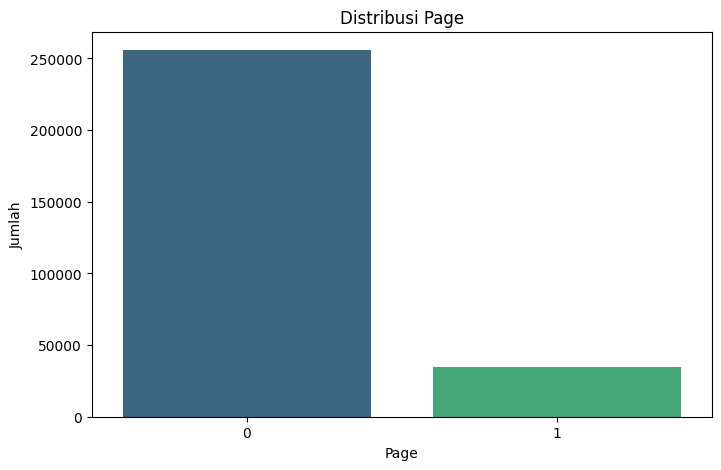

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi Distribusi 'page'
plt.figure(figsize=(8, 5))
sns.countplot(x='converted', data=data, palette='viridis')
plt.title('Distribusi Page')
plt.xlabel('Page')
plt.ylabel('Jumlah')
plt.show()

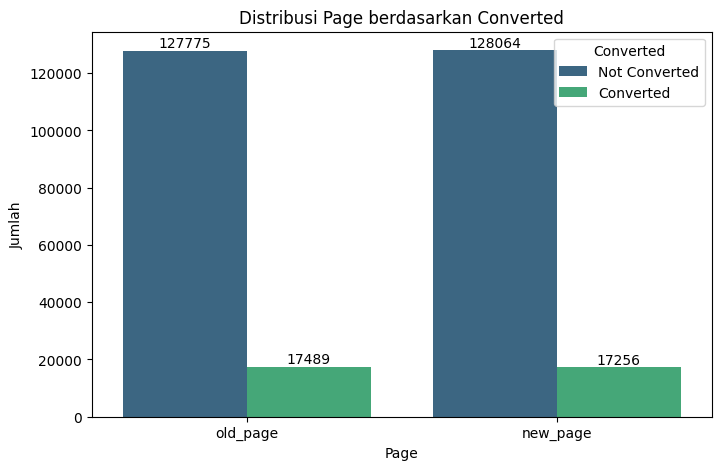

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisasi Distribusi 'page' berdasarkan 'converted'
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='page', hue='converted', data=data, palette='viridis')

# Menambahkan deskripsi jumlah di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title('Distribusi Page berdasarkan Converted')
plt.xlabel('Page')
plt.ylabel('Jumlah')
plt.legend(title='Converted', labels=['Not Converted', 'Converted'])
plt.show()


# A/B TESTING

In [ ]:
proporsi_konversi_control = control_group['converted'].mean()
proporsi_konversi_treatment = treatment_group['converted'].mean()

print(f"Proporsi Konversi Control: {proporsi_konversi_control:.2%}")
print(f"Proporsi Konversi Treatment: {proporsi_konversi_treatment:.2%}")


Proporsi Konversi Control: 12.03%
Proporsi Konversi Treatment: 11.88%


In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(data['con_treat'], data['converted'])
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")

Chi-square value: 1.446408325649827
P-value: 0.22910514252060252
